Intrinsics:
 [[465.20956421   0.         315.72366333]
 [  0.         461.64868164 249.76126099]
 [  0.           0.           1.        ]]
Relative Pose:
 [[ 0.55762746  0.0782717  -0.82639286 -5.39575618]
 [ 0.09862006  0.98224664  0.15957952 -1.59287788]
 [ 0.82421217 -0.17048483  0.54000854  8.62869813]
 [ 0.          0.          0.          1.        ]]


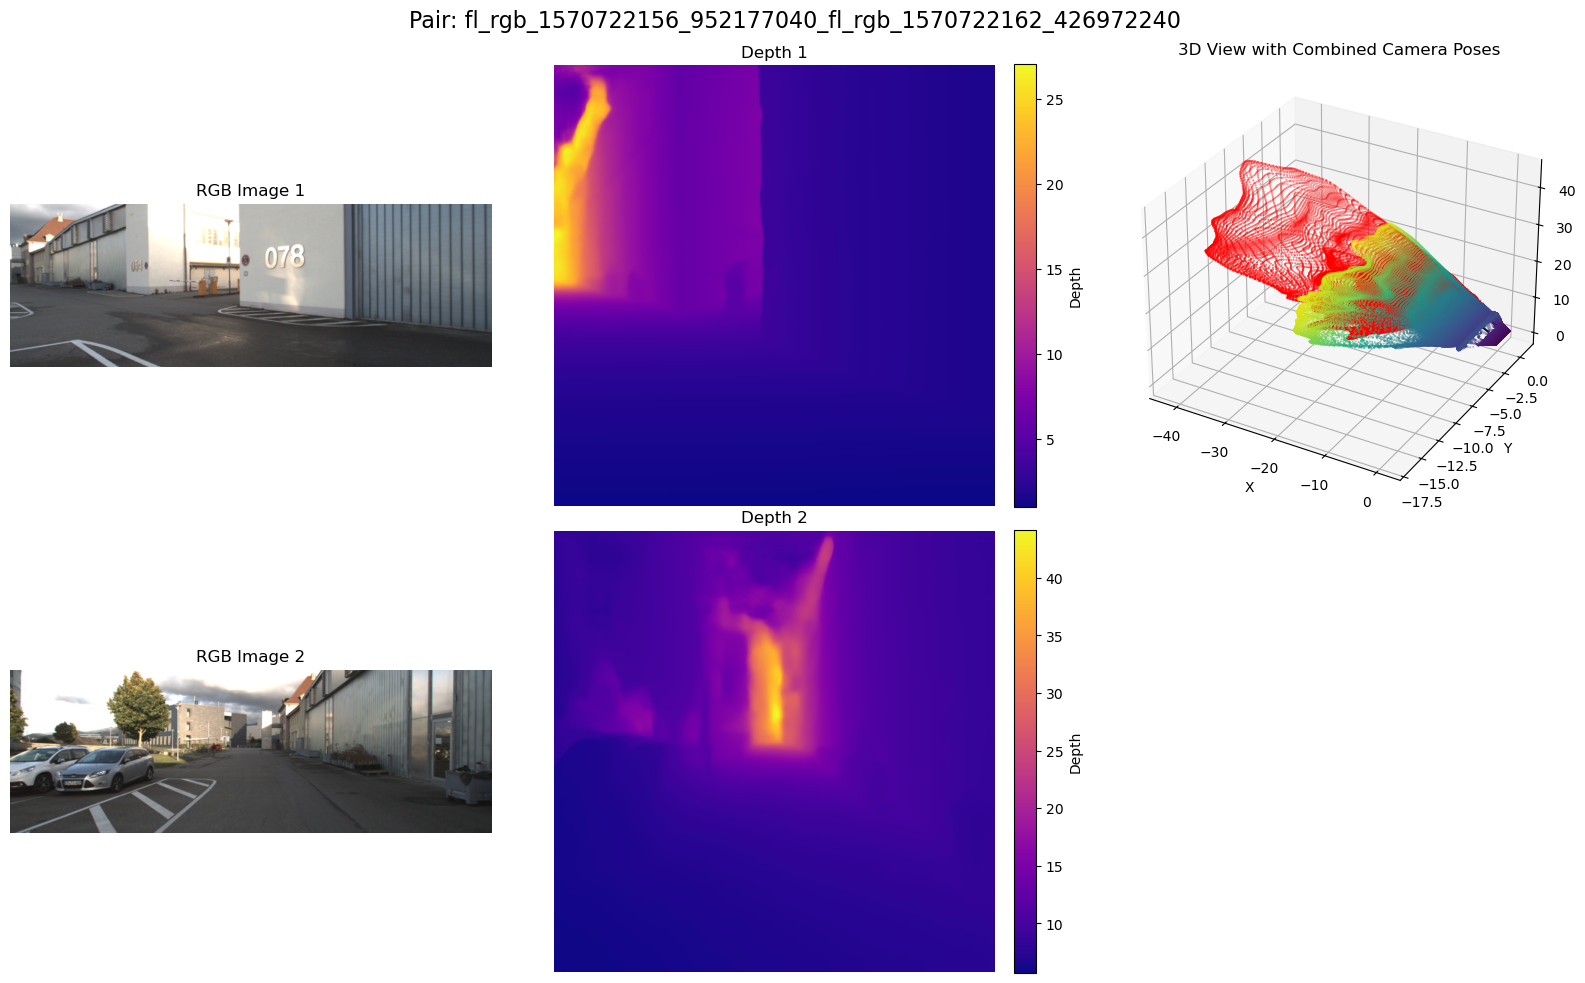

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

def load_rgb_image(path):
    """Load an RGB image with OpenCV, convert BGR->RGB."""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_depth(path):
    """Load depth from a .npy file (shape [H, W]) or from the Z channel of a pointmap."""
    depth = np.load(path)
    return depth

def load_pointmap(path):
    """Load a pointmap (shape [H, W, 3]) from .npy."""
    pm = np.load(path)
    return pm

def plot_point_cloud(ax, pointmap, color_mode='depth', point_size=1):
    """
    Scatter plot of a 3D pointmap in the given Axes3D (ax).
    color_mode can be 'depth' to color by Z or 'none' for single color.
    """
    H, W, _ = pointmap.shape
    points = pointmap.reshape(-1, 3)
    valid = np.isfinite(points).all(axis=1) & (points[:, 2] > 0)
    points = points[valid]
    
    # Color points by depth
    depths = points[:, 2]
    if color_mode == 'depth':
        cmin, cmax = depths.min(), depths.max()
        denom = (cmax - cmin) if (cmax > cmin) else 1.0
        colors = cm.viridis((depths - cmin) / denom)
    else:
        colors = 'blue'
    
    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               s=point_size, c=colors, marker='.')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
def plot_cameras(ax, pose1=None, pose2=None, size=0.1):
    """
    Plot camera frustums in 3D space.
    pose1 is assumed to be identity (reference frame)
    pose2 is the relative pose from camera 1 to camera 2
    """
    # Camera 1 (reference frame)
    # Draw camera coordinate system
    origin = np.array([0, 0, 0])
    x_axis = np.array([size, 0, 0])
    y_axis = np.array([0, size, 0])
    z_axis = np.array([0, 0, size])
    
    # Draw camera 1 (reference frame)
    ax.quiver(origin[0], origin[1], origin[2], 
              x_axis[0], x_axis[1], x_axis[2], color='r')
    ax.quiver(origin[0], origin[1], origin[2], 
              y_axis[0], y_axis[1], y_axis[2], color='g')
    ax.quiver(origin[0], origin[1], origin[2], 
              z_axis[0], z_axis[1], z_axis[2], color='b')
    
    # If we have pose2, draw camera 2
    if pose2 is not None:
        # Extract rotation and translation
        R = pose2[:3, :3]
        t = pose2[:3, 3]
        
        # Transform axes by rotation and translation
        x_axis_transformed = R @ np.array([size, 0, 0]) + t
        y_axis_transformed = R @ np.array([0, size, 0]) + t
        z_axis_transformed = R @ np.array([0, 0, size]) + t
        
        # Draw camera 2
        ax.quiver(t[0], t[1], t[2], 
                  x_axis_transformed[0]-t[0], x_axis_transformed[1]-t[1], x_axis_transformed[2]-t[2], color='r')
        ax.quiver(t[0], t[1], t[2], 
                  y_axis_transformed[0]-t[0], y_axis_transformed[1]-t[1], y_axis_transformed[2]-t[2], color='g')
        ax.quiver(t[0], t[1], t[2], 
                  z_axis_transformed[0]-t[0], z_axis_transformed[1]-t[1], z_axis_transformed[2]-t[2], color='b')
        
        # Draw a line connecting the two cameras
        ax.plot([origin[0], t[0]], [origin[1], t[1]], [origin[2], t[2]], 'k--')

def visualize_pair(
    rgb1_path, depth1_path, pm1_path,
    rgb2_path, depth2_path, pm2_path,
    intrinsics_path, pose_path,
    title="Pair Visualization"
):
    """
    Visualize a pair of images (RGB1 & RGB2), their depths, and their 3D pointmaps.
    Also display intrinsics and relative pose in the console or an optional subplot.
    """

    # Load data for view1
    rgb1 = load_rgb_image(rgb1_path)
    depth1 = load_depth(depth1_path)
    pm1 = load_pointmap(pm1_path)

    # Load data for view2
    rgb2 = load_rgb_image(rgb2_path)
    depth2 = load_depth(depth2_path)
    pm2 = load_pointmap(pm2_path)

    # Load intrinsics & pose
    intrinsics = np.load(intrinsics_path)  # shape [3,3]
    pose = np.load(pose_path)             # shape [4,4]

    # Print them to console
    print("Intrinsics:\n", intrinsics)
    print("Relative Pose:\n", pose)

    # Create figure
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(title, fontsize=16)

    # Subplot 1: RGB Image 1
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(rgb1)
    ax1.set_title("RGB Image 1")
    ax1.axis("off")

    # Subplot 2: Depth 1
    ax2 = fig.add_subplot(2, 3, 2)
    im2 = ax2.imshow(depth1, cmap="plasma")
    ax2.set_title("Depth 1")
    ax2.axis("off")
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label="Depth")

    # Subplot 4: RGB Image 2
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.imshow(rgb2)
    ax4.set_title("RGB Image 2")
    ax4.axis("off")

    # Subplot 5: Depth 2
    ax5 = fig.add_subplot(2, 3, 5)
    im5 = ax5.imshow(depth2, cmap="plasma")
    ax5.set_title("Depth 2")
    ax5.axis("off")
    fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04, label="Depth")

    # Combined 3D visualization with point clouds and cameras
    ax_combined = fig.add_subplot(2, 3, 3, projection='3d')
    plot_point_cloud(ax_combined, pm1, color_mode='depth', point_size=0.5)
    # Different color for second point cloud
    points = pm2.reshape(-1, 3)
    valid = np.isfinite(points).all(axis=1) & (points[:, 2] > 0)
    points = points[valid]
    ax_combined.scatter(points[:, 0], points[:, 1], points[:, 2], 
                       s=0.5, c='red', marker='.')
    
    # Add camera poses
    pose1 = np.eye(4)  # Identity for camera 1 (reference frame)
    plot_cameras(ax_combined, pose1=pose1, pose2=pose, size=0.2)
    
    ax_combined.set_title("3D View with Combined Camera Poses")

    plt.tight_layout()
    plt.show()


# Example usage:
if __name__ == "__main__":
    # Just an example. Adjust these paths to your actual files:
    pair_name = "fl_rgb_1570722156_952177040_fl_rgb_1570722162_426972240"
    pseudo_gt_dir = "pseudo_gt_data"

    # For view1, base_name1 is "fl_rgb_1570722156_952177040"
    # For view2, base_name2 is "fl_rgb_1570722162_426972240"
    base_name1, base_name2 = pair_name.split("_fl_rgb_", 1)
    base_name2 = "fl_rgb_" + base_name2  # reconstruct second half

    # Paths
    rgb1_path = "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722156_952177040.png"
    depth1_path = os.path.join(pseudo_gt_dir, "depth1", f"{base_name1}.npy")
    pm1_path = os.path.join(pseudo_gt_dir, "pointmap1", f"{pair_name}.npy")

    rgb2_path = "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722162_426972240.png"
    depth2_path = os.path.join(pseudo_gt_dir, "depth2", f"{base_name2}.npy")
    pm2_path = os.path.join(pseudo_gt_dir, "pointmap2", f"{pair_name}.npy")

    intrinsics_path = os.path.join(pseudo_gt_dir, "intrinsics", f"{pair_name}.npy")
    pose_path = os.path.join(pseudo_gt_dir, "poses", f"{pair_name}.npy")

    # Visualize
    visualize_pair(rgb1_path, depth1_path, pm1_path,
                   rgb2_path, depth2_path, pm2_path,
                   intrinsics_path, pose_path,
                   title=f"Pair: {pair_name}")


Found 20609 files in pointmap1_dir

=== Visualizing pair: fl_rgb_1570722156_952177040_fl_rgb_1570722162_426972240 ===
RGB1: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722156_952177040.png
Depth1: pseudo_gt_data/depth1/fl_rgb_1570722156_952177040.npy (512, 512)
Pointmap1: pseudo_gt_data/pointmap1/fl_rgb_1570722156_952177040_fl_rgb_1570722162_426972240.npy (512, 512, 3)
RGB2: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722162_426972240.png
Depth2: pseudo_gt_data/depth2/fl_rgb_1570722162_426972240.npy (512, 512)
Pointmap2: pseudo_gt_data/pointmap2/fl_rgb_1570722156_952177040_fl_rgb_1570722162_426972240.npy (512, 512, 3)
Intrinsics: pseudo_gt_data/intrinsics/fl_rgb_1570722156_952177040_fl_rgb_1570722162_426972240.npy (exists?  True )
Pose: pseudo_gt_data/poses/fl_rgb_1570722156_952177040_fl_rgb_1570722162_426972240.npy (exists?  True )


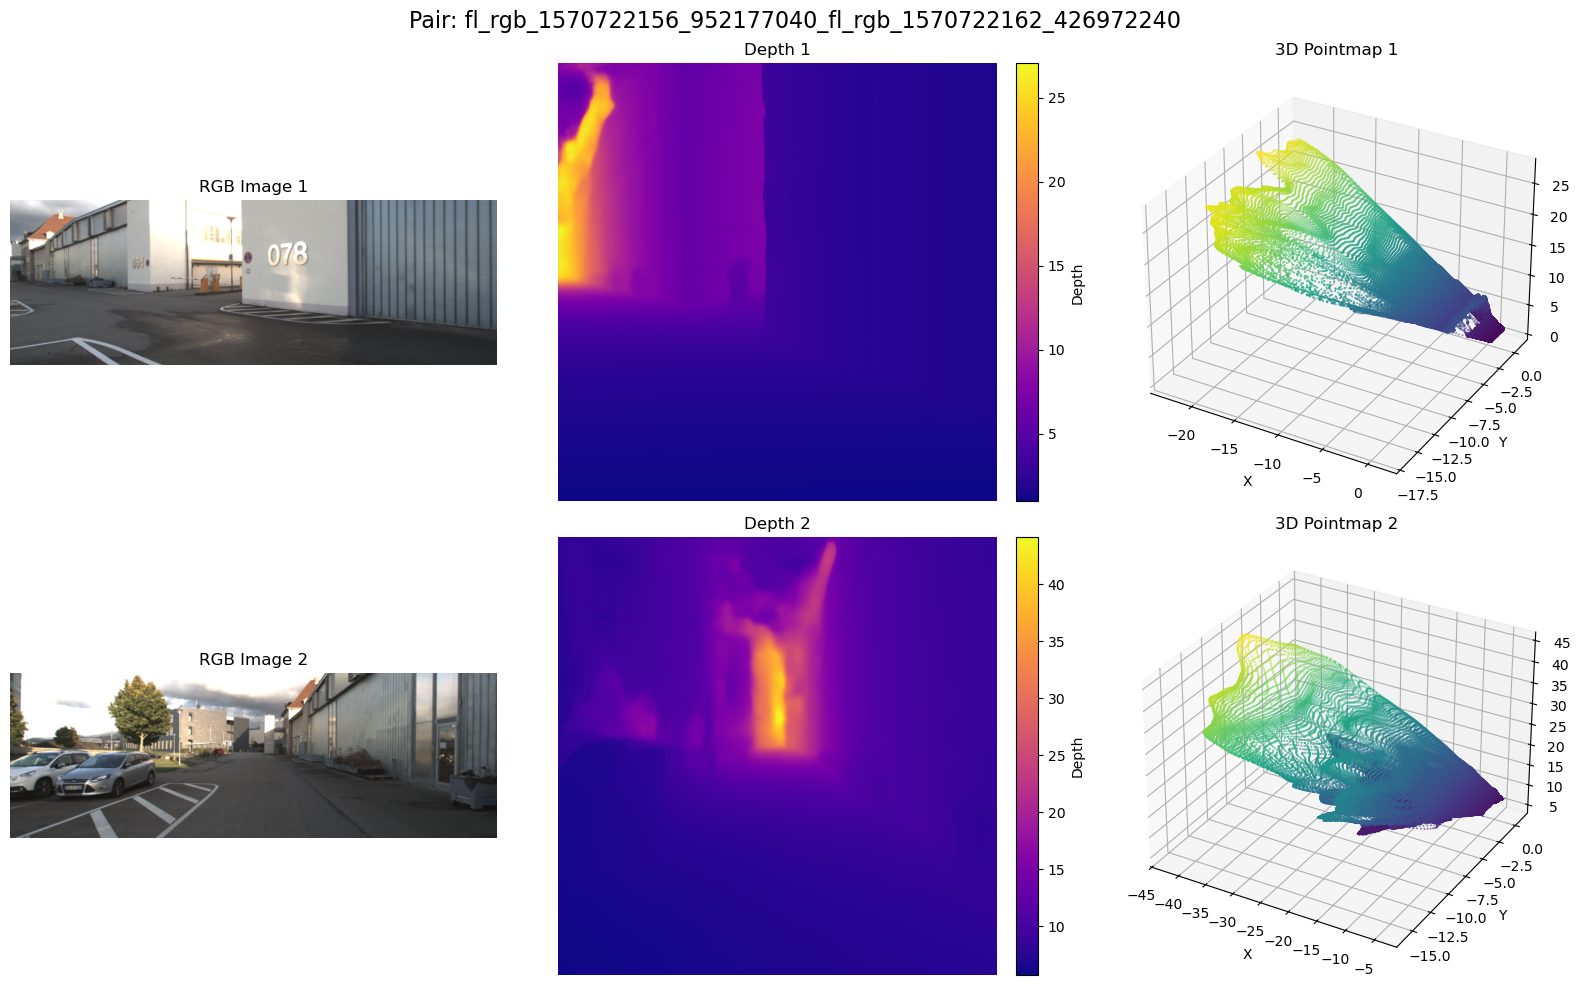

Saved figure to: visualized_pairs/fl_rgb_1570722156_952177040_fl_rgb_1570722162_426972240.png

=== Visualizing pair: fl_rgb_1570722157_2840648400_fl_rgb_1570722163_2325205760 ===
RGB1: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722157_2840648400.png
Depth1: pseudo_gt_data/depth1/fl_rgb_1570722157_2840648400.npy (512, 512)
Pointmap1: pseudo_gt_data/pointmap1/fl_rgb_1570722157_2840648400_fl_rgb_1570722163_2325205760.npy (512, 512, 3)
RGB2: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722163_2325205760.png
Depth2: pseudo_gt_data/depth2/fl_rgb_1570722163_2325205760.npy (512, 512)
Pointmap2: pseudo_gt_data/pointmap2/fl_rgb_1570722157_2840648400_fl_rgb_1570722163_2325205760.npy (512, 512, 3)
Intrinsics: pseudo_gt_data/intrinsics/fl_rgb_1570722157_2840648400_fl_rgb_1570722163_2325205760.npy (exists?  True )
Pose: pseudo_gt_data/poses/fl_rgb_1570722157_2840648400_fl_rgb_1570722163_2325205760.npy (exists?  Tru

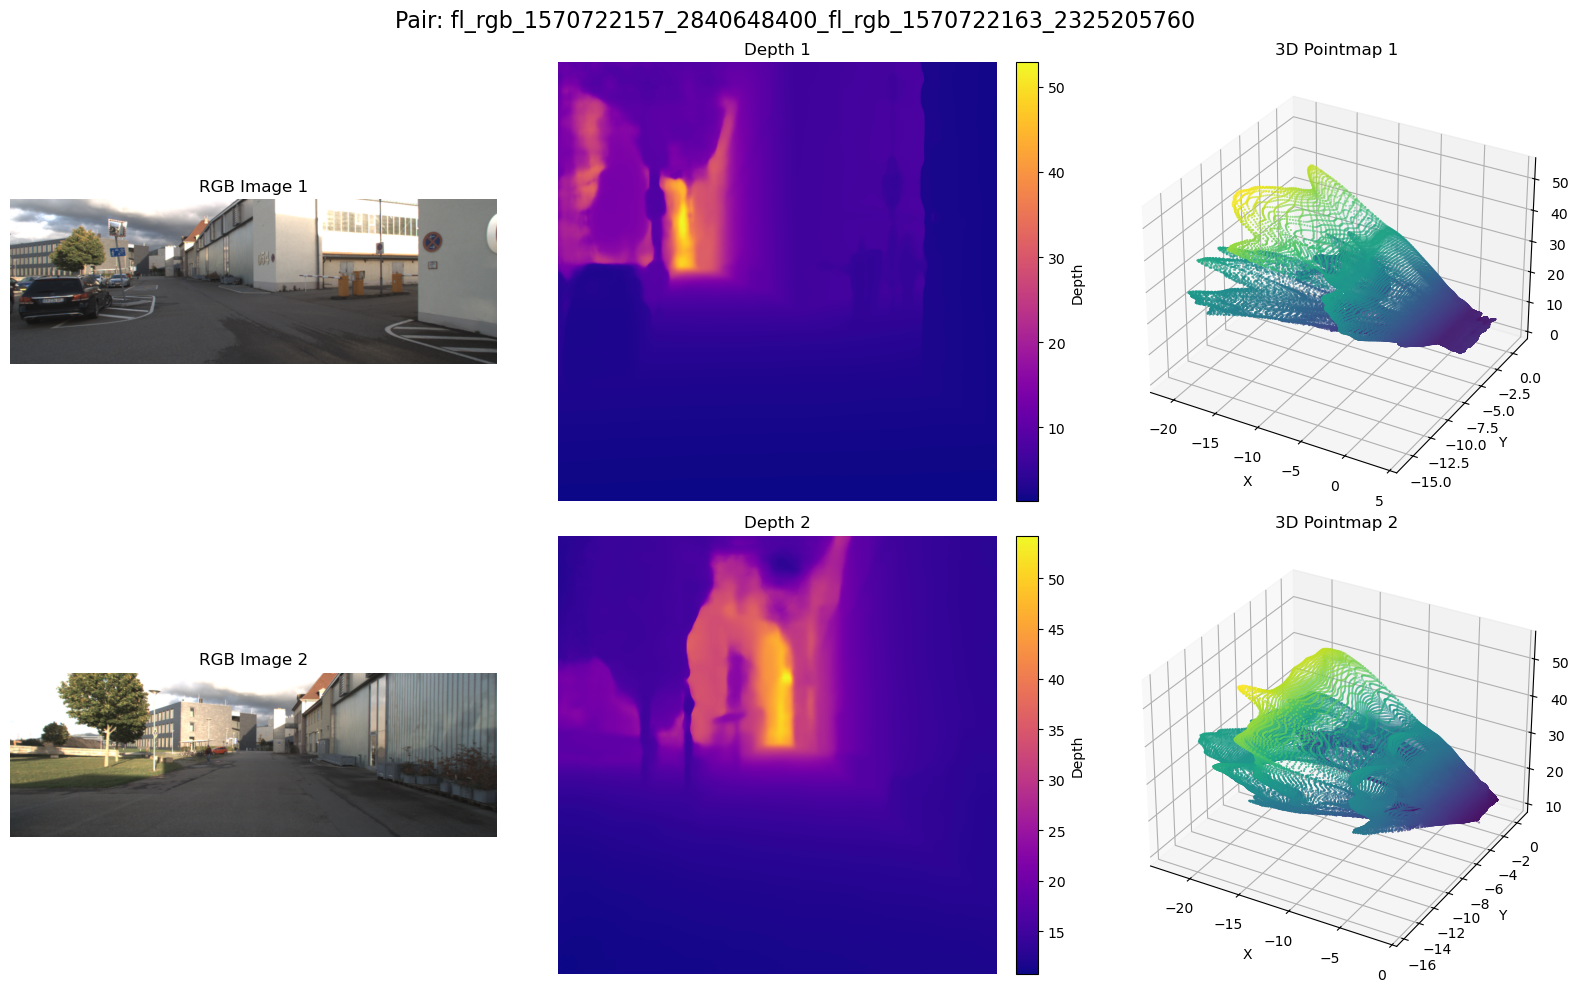

Saved figure to: visualized_pairs/fl_rgb_1570722157_2840648400_fl_rgb_1570722163_2325205760.png

=== Visualizing pair: fl_rgb_1570722158_4732192720_fl_rgb_1570722164_4221705760 ===
RGB1: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722158_4732192720.png
Depth1: pseudo_gt_data/depth1/fl_rgb_1570722158_4732192720.npy (512, 512)
Pointmap1: pseudo_gt_data/pointmap1/fl_rgb_1570722158_4732192720_fl_rgb_1570722164_4221705760.npy (512, 512, 3)
RGB2: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722164_4221705760.png
Depth2: pseudo_gt_data/depth2/fl_rgb_1570722164_4221705760.npy (512, 512)
Pointmap2: pseudo_gt_data/pointmap2/fl_rgb_1570722158_4732192720_fl_rgb_1570722164_4221705760.npy (512, 512, 3)
Intrinsics: pseudo_gt_data/intrinsics/fl_rgb_1570722158_4732192720_fl_rgb_1570722164_4221705760.npy (exists?  True )
Pose: pseudo_gt_data/poses/fl_rgb_1570722158_4732192720_fl_rgb_1570722164_4221705760.npy (exists?  T

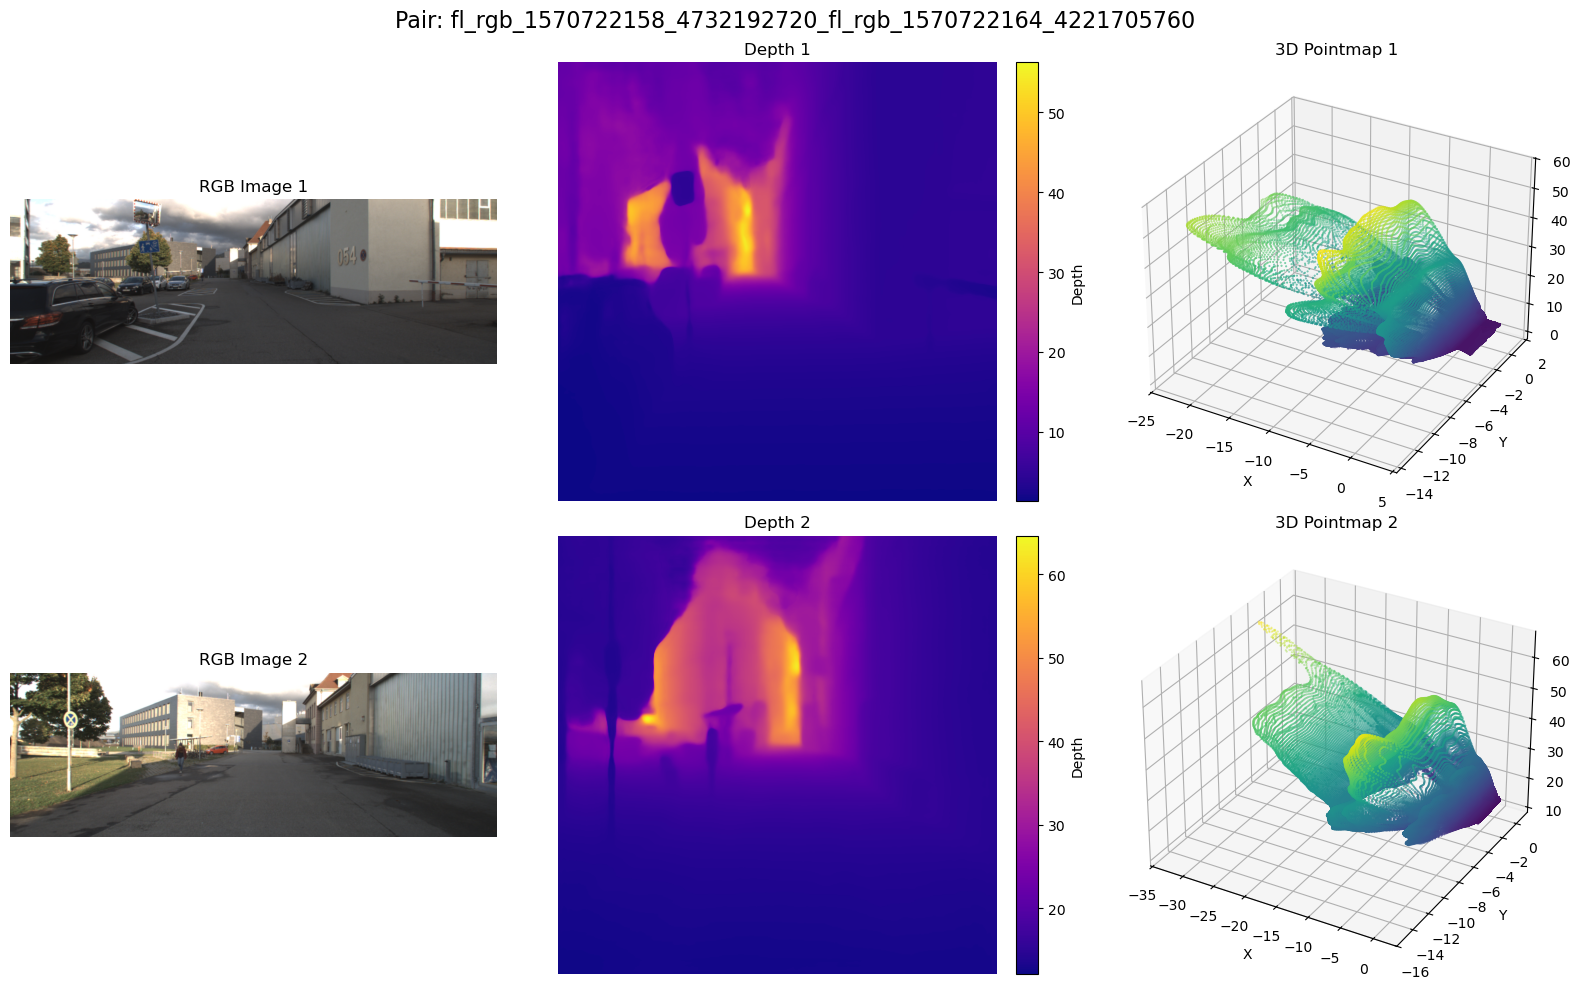

Saved figure to: visualized_pairs/fl_rgb_1570722158_4732192720_fl_rgb_1570722164_4221705760.png

=== Visualizing pair: fl_rgb_1570722159_6632197360_fl_rgb_1570722165_6115748720 ===
RGB1: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722159_6632197360.png
Depth1: pseudo_gt_data/depth1/fl_rgb_1570722159_6632197360.npy (512, 512)
Pointmap1: pseudo_gt_data/pointmap1/fl_rgb_1570722159_6632197360_fl_rgb_1570722165_6115748720.npy (512, 512, 3)
RGB2: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722165_6115748720.png
Depth2: pseudo_gt_data/depth2/fl_rgb_1570722165_6115748720.npy (512, 512)
Pointmap2: pseudo_gt_data/pointmap2/fl_rgb_1570722159_6632197360_fl_rgb_1570722165_6115748720.npy (512, 512, 3)
Intrinsics: pseudo_gt_data/intrinsics/fl_rgb_1570722159_6632197360_fl_rgb_1570722165_6115748720.npy (exists?  True )
Pose: pseudo_gt_data/poses/fl_rgb_1570722159_6632197360_fl_rgb_1570722165_6115748720.npy (exists?  T

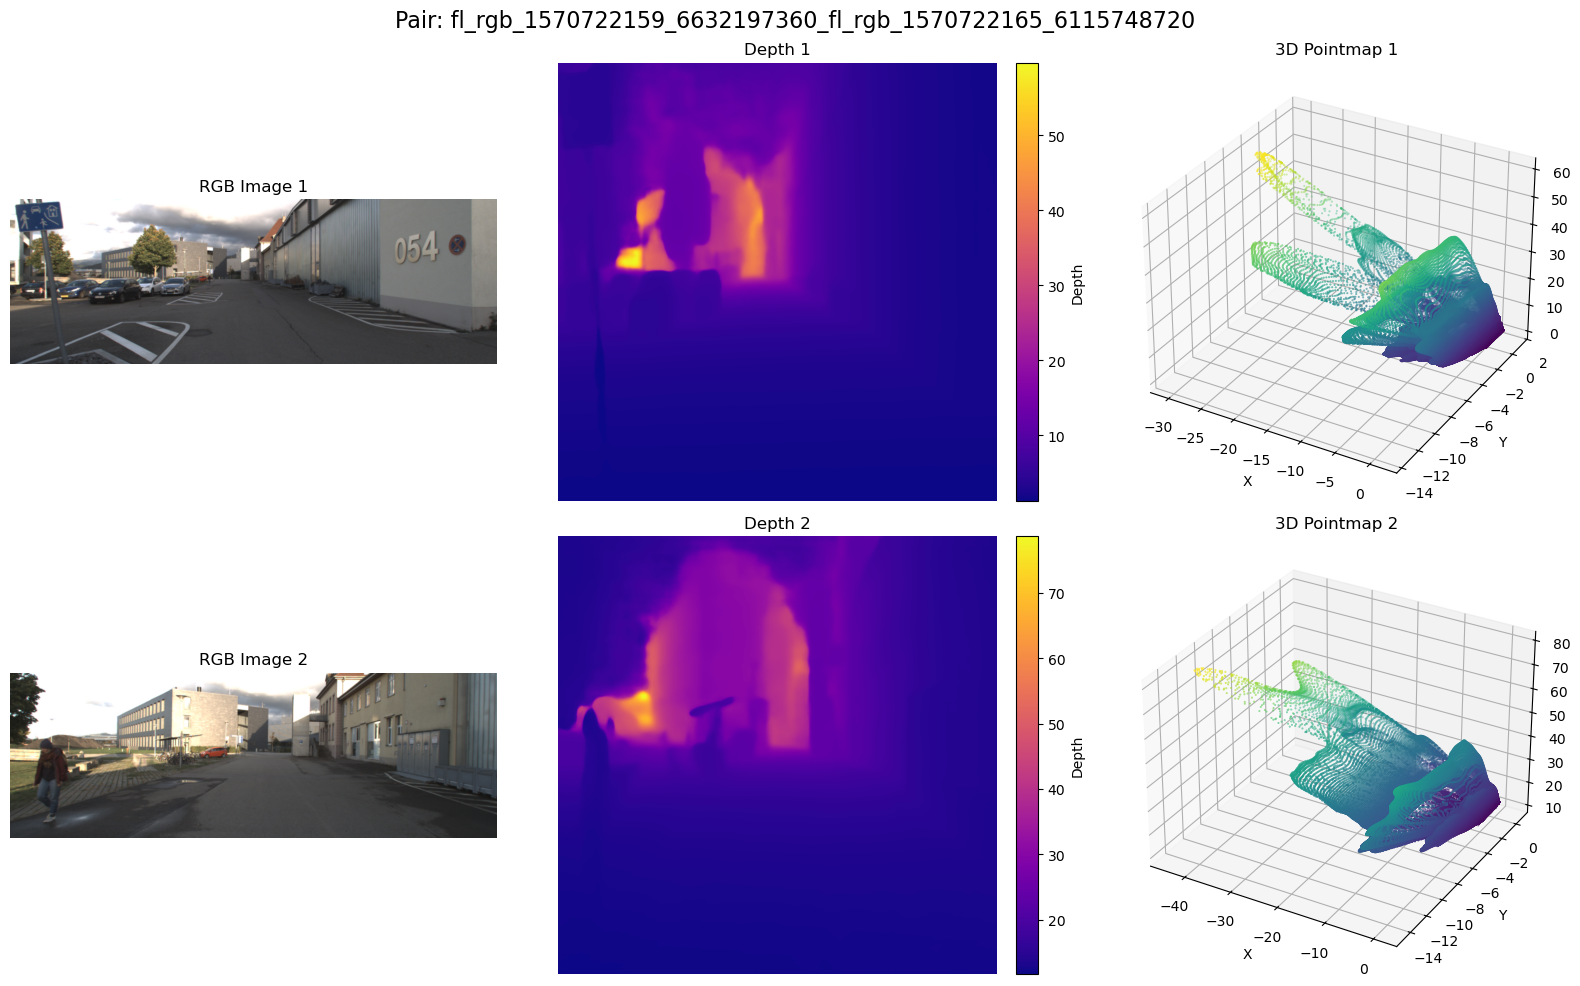

Saved figure to: visualized_pairs/fl_rgb_1570722159_6632197360_fl_rgb_1570722165_6115748720.png

=== Visualizing pair: fl_rgb_1570722160_8531107920_fl_rgb_1570722166_8006145200 ===
RGB1: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722160_8531107920.png
Depth1: pseudo_gt_data/depth1/fl_rgb_1570722160_8531107920.npy (512, 512)
Pointmap1: pseudo_gt_data/pointmap1/fl_rgb_1570722160_8531107920_fl_rgb_1570722166_8006145200.npy (512, 512, 3)
RGB2: /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722166_8006145200.png
Depth2: pseudo_gt_data/depth2/fl_rgb_1570722166_8006145200.npy (512, 512)
Pointmap2: pseudo_gt_data/pointmap2/fl_rgb_1570722160_8531107920_fl_rgb_1570722166_8006145200.npy (512, 512, 3)
Intrinsics: pseudo_gt_data/intrinsics/fl_rgb_1570722160_8531107920_fl_rgb_1570722166_8006145200.npy (exists?  True )
Pose: pseudo_gt_data/poses/fl_rgb_1570722160_8531107920_fl_rgb_1570722166_8006145200.npy (exists?  T

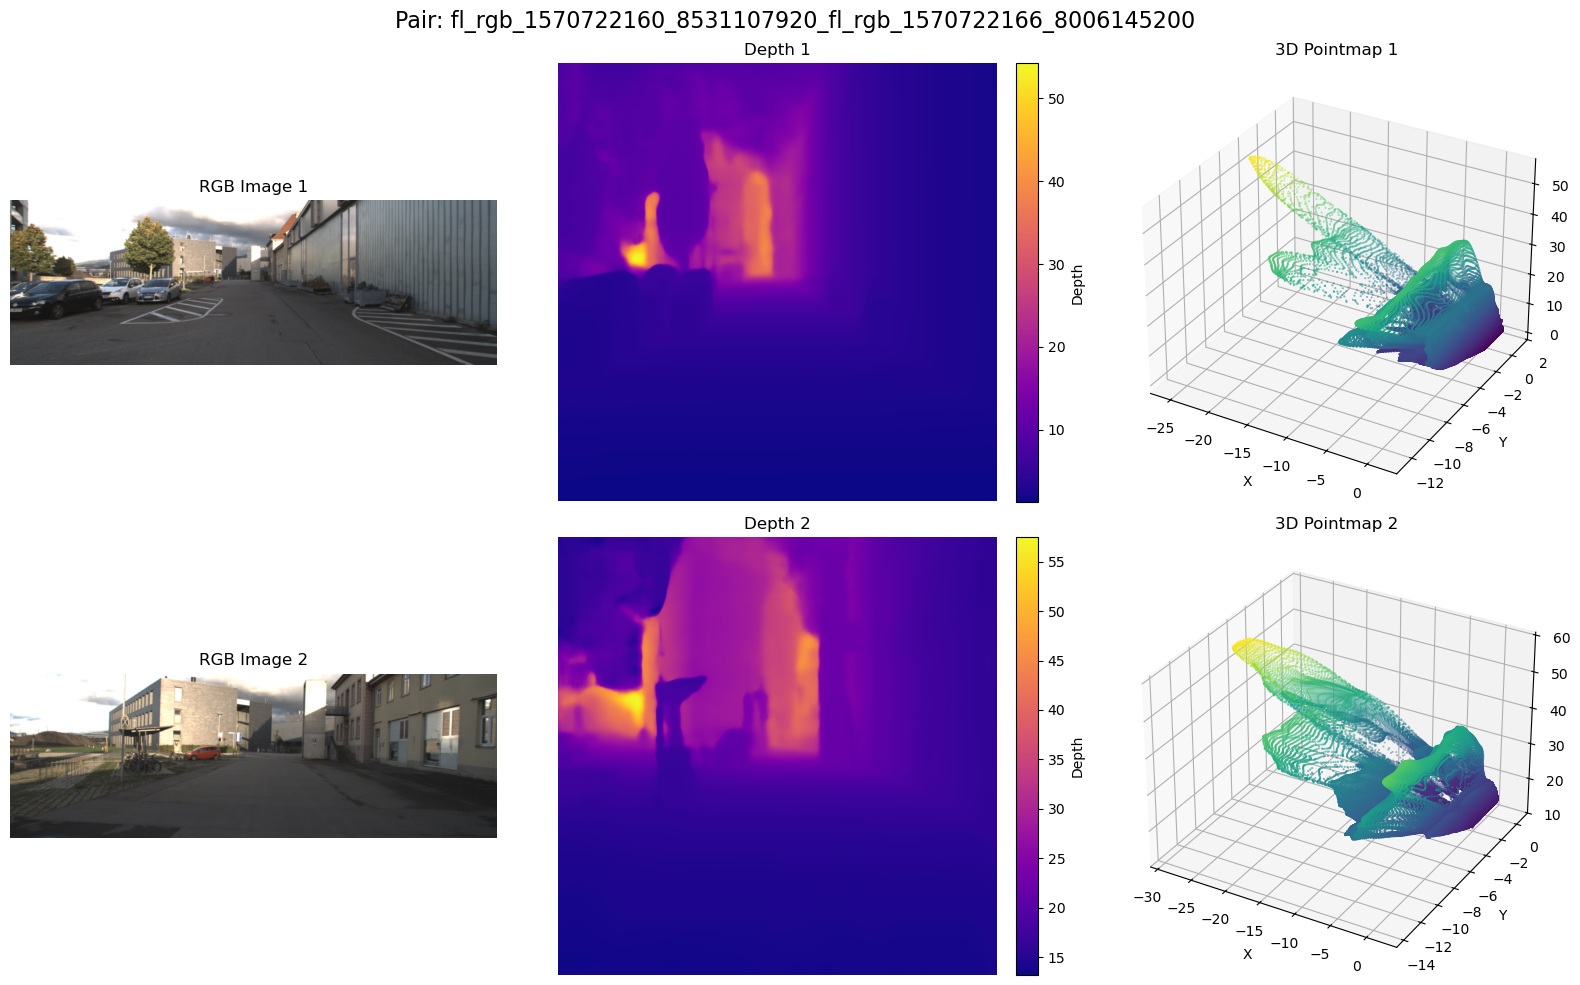

Saved figure to: visualized_pairs/fl_rgb_1570722160_8531107920_fl_rgb_1570722166_8006145200.png


In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

def load_rgb_image(path):
    """Load an RGB image with OpenCV, convert BGR->RGB."""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_depth(path):
    """Load depth from a .npy file (shape [H, W])."""
    depth = np.load(path)
    return depth

def load_pointmap(path):
    """Load a pointmap (shape [H, W, 3]) from .npy."""
    pm = np.load(path)
    return pm

def plot_point_cloud(ax, pointmap, color_mode='depth', point_size=1):
    """
    Scatter plot of a 3D pointmap in the given Axes3D (ax).
    color_mode can be 'depth' to color by Z or 'none' for single color.
    """
    H, W, _ = pointmap.shape
    points = pointmap.reshape(-1, 3)
    valid = np.isfinite(points).all(axis=1) & (points[:, 2] > 0)
    points = points[valid]
    
    # Color points by depth
    depths = points[:, 2]
    if depths.size == 0:
        # If no valid points, just skip
        return
    if color_mode == 'depth':
        cmin, cmax = depths.min(), depths.max()
        denom = (cmax - cmin) if (cmax > cmin) else 1.0
        colors = cm.viridis((depths - cmin) / denom)
    else:
        colors = 'blue'
    
    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               s=point_size, c=colors, marker='.')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

def visualize_pair(
    rgb1_path, depth1_path, pm1_path,
    rgb2_path, depth2_path, pm2_path,
    intrinsics_path, pose_path,
    out_dir="visualized_pairs",
    pair_name="unknown_pair",
    title="Pair Visualization"
):
    """
    Visualize a pair of images (RGB1 & RGB2), their depths, and their 3D pointmaps.
    """

    # Load data for view1
    rgb1 = load_rgb_image(rgb1_path)
    depth1 = load_depth(depth1_path)
    pm1 = load_pointmap(pm1_path)

    # Load data for view2
    rgb2 = load_rgb_image(rgb2_path)
    depth2 = load_depth(depth2_path)
    pm2 = load_pointmap(pm2_path)

    # Load intrinsics & pose
    if os.path.exists(intrinsics_path):
        intrinsics = np.load(intrinsics_path)
    else:
        intrinsics = None
    
    if os.path.exists(pose_path):
        pose = np.load(pose_path)
    else:
        pose = None

    # Print them to console
    print(f"\n=== Visualizing pair: {pair_name} ===")
    print("RGB1:", rgb1_path)
    print("Depth1:", depth1_path, depth1.shape)
    print("Pointmap1:", pm1_path, pm1.shape)
    print("RGB2:", rgb2_path)
    print("Depth2:", depth2_path, depth2.shape)
    print("Pointmap2:", pm2_path, pm2.shape)
    print("Intrinsics:", intrinsics_path, "(exists? ", os.path.exists(intrinsics_path), ")")
    print("Pose:", pose_path, "(exists? ", os.path.exists(pose_path), ")")

    # Create figure
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(title, fontsize=16)

    # Subplot 1: RGB Image 1
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(rgb1)
    ax1.set_title("RGB Image 1")
    ax1.axis("off")

    # Subplot 2: Depth 1
    ax2 = fig.add_subplot(2, 3, 2)
    im2 = ax2.imshow(depth1, cmap="plasma")
    ax2.set_title("Depth 1")
    ax2.axis("off")
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label="Depth")

    # Subplot 3: Point Cloud 1
    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    plot_point_cloud(ax3, pm1, color_mode='depth')
    ax3.set_title("3D Pointmap 1")

    # Subplot 4: RGB Image 2
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.imshow(rgb2)
    ax4.set_title("RGB Image 2")
    ax4.axis("off")

    # Subplot 5: Depth 2
    ax5 = fig.add_subplot(2, 3, 5)
    im5 = ax5.imshow(depth2, cmap="plasma")
    ax5.set_title("Depth 2")
    ax5.axis("off")
    fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04, label="Depth")

    # Subplot 6: Point Cloud 2
    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    plot_point_cloud(ax6, pm2, color_mode='depth')
    ax6.set_title("3D Pointmap 2")

    plt.tight_layout()

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{pair_name}.png")
    plt.show()
    plt.savefig(out_path)
    plt.close()
    print(f"Saved figure to: {out_path}")


if __name__ == "__main__":
    pseudo_gt_dir = "pseudo_gt_data"


    pm1_dir = os.path.join(pseudo_gt_dir, "pointmap1")
    pm1_files = sorted(glob.glob(os.path.join(pm1_dir, "*.npy")))
    print("Found", len(pm1_files), "files in pointmap1_dir")
    
    for pm1_file in pm1_files[:5]:
        pair_name = os.path.splitext(os.path.basename(pm1_file))[0]
        
        if "_fl_rgb_" not in pair_name:
            print(f"Skipping {pair_name}, doesn't match expected pattern.")
            continue

        base_name1, base_name2 = pair_name.split("_fl_rgb_", 1)
        base_name2 = "fl_rgb_" + base_name2

        # Build the paths
        rgb1_path = os.path.join(
            "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb",
            f"{base_name1}.png"
        )
        depth1_path = os.path.join(pseudo_gt_dir, "depth1", f"{base_name1}.npy")
        pm1_path = os.path.join(pseudo_gt_dir, "pointmap1", f"{pair_name}.npy")

        rgb2_path = os.path.join(
            "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb",
            f"{base_name2}.png"
        )
        depth2_path = os.path.join(pseudo_gt_dir, "depth2", f"{base_name2}.npy")
        pm2_path = os.path.join(pseudo_gt_dir, "pointmap2", f"{pair_name}.npy")

        intrinsics_path = os.path.join(pseudo_gt_dir, "intrinsics", f"{pair_name}.npy")
        pose_path = os.path.join(pseudo_gt_dir, "poses", f"{pair_name}.npy")

        if not (os.path.exists(rgb1_path) and os.path.exists(rgb2_path)):
            print(f"Missing RGB images for {pair_name}. Skipping.")
            continue
        if not (os.path.exists(depth1_path) and os.path.exists(depth2_path)):
            print(f"Missing depth for {pair_name}. Skipping.")
            continue
        if not (os.path.exists(pm1_path) and os.path.exists(pm2_path)):
            print(f"Missing pointmaps for {pair_name}. Skipping.")
            continue

        visualize_pair(
            rgb1_path, depth1_path, pm1_path,
            rgb2_path, depth2_path, pm2_path,
            intrinsics_path, pose_path,
            out_dir="visualized_pairs",
            pair_name=pair_name,
            title=f"Pair: {pair_name}"
        )
